In [ ]:
# Step 1: Imports & Configuration

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [26]:
DATA_PATH = "/content/time-series forecasting.csv"

df = pd.read_csv(DATA_PATH)

print(df.columns)  # always check once

df['Date Time'] = pd.to_datetime(
    df['Date Time'],
    errors='coerce',
    infer_datetime_format=True
)

df = df.dropna(subset=['Date Time'])
df.set_index('Date Time', inplace=True)
df.head()

# Select multivariate features
features = [
    'T (degC)', 'p (mbar)', 'rh (%)', 'wv (m/s)', 'wd (deg)'
]

data = df[features]

Index(['Date Time', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)',
       'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)'],
      dtype='object')


/tmp/ipython-input-2828897187.py:7: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['Date Time'] = pd.to_datetime(


In [27]:
# Step 3: Train–Validation Split (Time-Series Safe)
train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.15)

train_data = data.iloc[:train_size]
val_data = data.iloc[train_size:train_size+val_size]
test_data = data.iloc[train_size+val_size:]


In [28]:
# Step 4: Scaling
scaler = StandardScaler()

train_scaled = scaler.fit_transform(train_data)
val_scaled = scaler.transform(val_data)
test_scaled = scaler.transform(test_data)

In [29]:
# Step 5: Sequence Dataset Builder
class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_len=48):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.seq_len = seq_len

    def __len__(self):
        return len(self.data) - self.seq_len

    def __getitem__(self, idx):
        x = self.data[idx:idx+self.seq_len]
        y = self.data[idx+self.seq_len, 0]  # Forecast temperature
        return x, y

In [30]:
# Step 6: DataLoaders
SEQ_LEN = 48
BATCH_SIZE = 64

train_ds = TimeSeriesDataset(train_scaled, SEQ_LEN)
val_ds = TimeSeriesDataset(val_scaled, SEQ_LEN)
test_ds = TimeSeriesDataset(test_scaled, SEQ_LEN)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

In [31]:
# Step 7: Baseline LSTM Model (No Attention)
class LSTMBaseline(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1])

In [32]:
# Step 8: LSTM with Temporal Attention (KEY PART)
class AttentionLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.attention = nn.Linear(hidden_dim, 1)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)

        attn_weights = torch.softmax(
            self.attention(lstm_out).squeeze(-1), dim=1
        )

        context = torch.sum(lstm_out * attn_weights.unsqueeze(-1), dim=1)
        output = self.fc(context)

        return output, attn_weights

In [33]:
# Step 9: Training Loop (Walk-Forward Compatible)
def train_model(model, loader, optimizer, criterion):
    model.train()
    losses = []

    for x, y in loader:
        optimizer.zero_grad()
        preds = model(x)[0] if isinstance(model(x), tuple) else model(x)
        loss = criterion(preds.squeeze(), y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    return np.mean(losses)

In [35]:
# Step 10: Model Training
input_dim = len(features)
hidden_dim = 64

baseline = LSTMBaseline(input_dim, hidden_dim)
attention_model = AttentionLSTM(input_dim, hidden_dim)

criterion = nn.MSELoss()
optimizer_base = torch.optim.Adam(baseline.parameters(), lr=0.001)
optimizer_attn = torch.optim.Adam(attention_model.parameters(), lr=0.001)

EPOCHS = 10

for epoch in range(EPOCHS):
    base_loss = train_model(baseline, train_loader, optimizer_base, criterion)
    attn_loss = train_model(attention_model, train_loader, optimizer_attn, criterion)

    print(f"Epoch {epoch+1} | Baseline: {base_loss:.4f} | Attention: {attn_loss:.4f}")

Epoch 1 | Baseline: 0.0786 | Attention: 0.1492
Epoch 2 | Baseline: 0.0056 | Attention: 0.0444
Epoch 3 | Baseline: 0.0023 | Attention: 0.0118
Epoch 4 | Baseline: 0.0020 | Attention: 0.0049
Epoch 5 | Baseline: 0.0018 | Attention: 0.0028
Epoch 6 | Baseline: 0.0013 | Attention: 0.0028
Epoch 7 | Baseline: 0.0012 | Attention: 0.0023
Epoch 8 | Baseline: 0.0011 | Attention: 0.0016
Epoch 9 | Baseline: 0.0012 | Attention: 0.0015
Epoch 10 | Baseline: 0.0011 | Attention: 0.0016


In [44]:
# Step 11: Quantitative Evaluation (Baseline vs Attention)

baseline_rmse, baseline_mae = evaluate(baseline, val_loader)
attn_rmse, attn_mae = evaluate(attention_model, val_loader)

print("Validation Results")
print(f"Baseline LSTM  -> RMSE: {baseline_rmse:.4f}, MAE: {baseline_mae:.4f}")
print(f"Attention LSTM -> RMSE: {attn_rmse:.4f}, MAE: {attn_mae:.4f}")


Validation Results
Baseline LSTM  -> RMSE: 0.0356, MAE: 0.0250
Attention LSTM -> RMSE: 0.0385, MAE: 0.0303


In [45]:
# Step 12b: Attention Interpretation

attn_np = attention_weights.squeeze().detach().cpu().numpy()

top_k = 5
top_indices = np.argsort(attn_np)[-top_k:][::-1]

print("Top influential time steps:")
for idx in top_indices:
    print(f"Time step {idx} -> weight {attn_np[idx]:.4f}")



Top influential time steps:
Time step 47 -> weight 0.6244
Time step 46 -> weight 0.2370
Time step 45 -> weight 0.0819
Time step 44 -> weight 0.0322
Time step 43 -> weight 0.0130


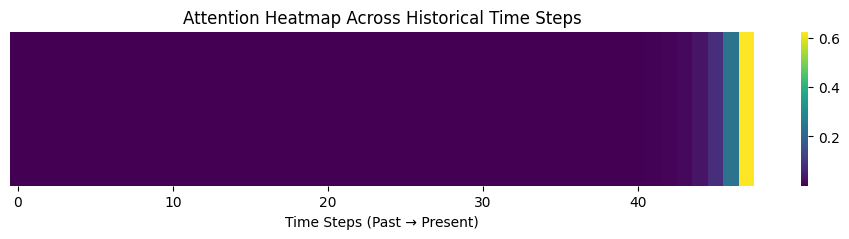

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert attention weights to numpy (already detached)
attn = attention_np.reshape(1, -1)  # shape: (1, time_steps)

plt.figure(figsize=(12, 2))
sns.heatmap(
    attn,
    cmap="viridis",
    cbar=True,
    xticklabels=10,
    yticklabels=False
)
plt.title("Attention Heatmap Across Historical Time Steps")
plt.xlabel("Time Steps (Past → Present)")
plt.show()


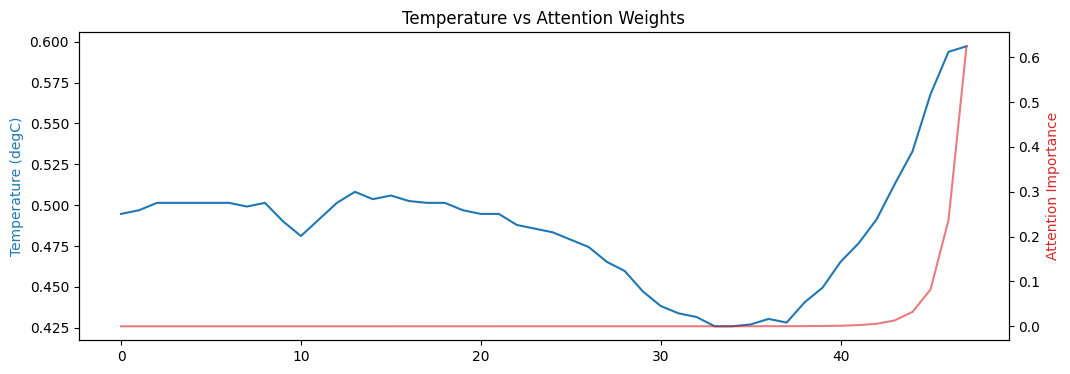

In [40]:
# Assuming first feature is temperature
temperature_series = x_sample.squeeze()[..., 0].detach().cpu().numpy()

fig, ax1 = plt.subplots(figsize=(12, 4))

# Temperature
ax1.plot(temperature_series, label="Temperature", color="tab:blue")
ax1.set_ylabel("Temperature (degC)", color="tab:blue")

# Attention
ax2 = ax1.twinx()
ax2.plot(attention_np, label="Attention Weight", color="tab:red", alpha=0.6)
ax2.set_ylabel("Attention Importance", color="tab:red")

plt.title("Temperature vs Attention Weights")
plt.xlabel("Historical Time Steps")
plt.show()


In [41]:
import numpy as np

top_k = 5
top_indices = np.argsort(attention_np)[-top_k:][::-1]

print("Top Important Time Steps (0 = oldest):")
for idx in top_indices:
    print(f"Time step {idx} → Attention = {attention_np[idx]:.4f}")


Top Important Time Steps (0 = oldest):
Time step 47 → Attention = 0.6244
Time step 46 → Attention = 0.2370
Time step 45 → Attention = 0.0819
Time step 44 → Attention = 0.0322
Time step 43 → Attention = 0.0130


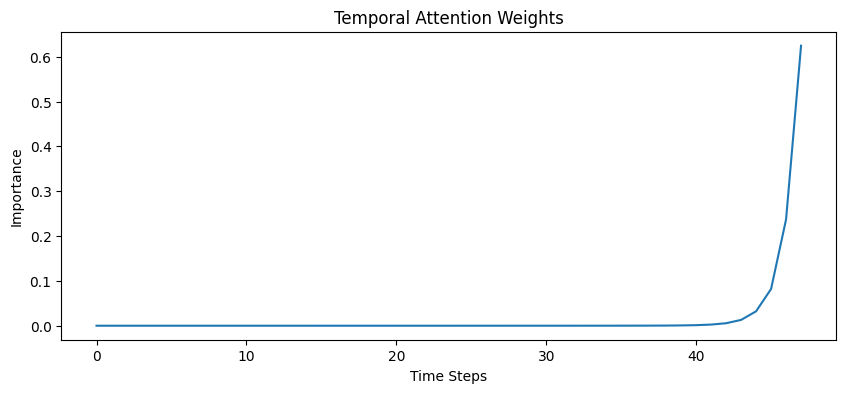

In [43]:
plt.figure(figsize=(10, 4))
plt.plot(attention_np)
plt.title("Temporal Attention Weights")
plt.xlabel("Time Steps")
plt.ylabel("Importance")
plt.savefig("attention_weights_plot.png", dpi=300)
plt.show()


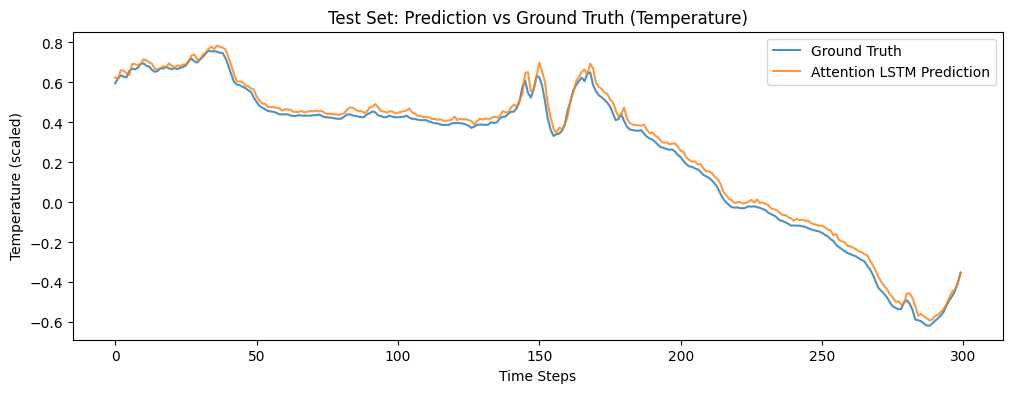

In [48]:
# Step 14: Prediction vs Ground Truth Visualization

def get_predictions(model, dataset, n=300):
    model.eval()
    preds, targets = [], []

    with torch.no_grad():
        for i in range(n):
            x, y = dataset[i]
            out = model(x.unsqueeze(0))[0] if isinstance(model(x.unsqueeze(0)), tuple) else model(x.unsqueeze(0))
            preds.append(out.item())
            targets.append(y.item())

    return preds, targets


# Attention model predictions
preds, targets = get_predictions(attention_model, test_ds)

plt.figure(figsize=(12,4))
plt.plot(targets, label="Ground Truth", alpha=0.8)
plt.plot(preds, label="Attention LSTM Prediction", alpha=0.8)
plt.title("Test Set: Prediction vs Ground Truth (Temperature)")
plt.xlabel("Time Steps")
plt.ylabel("Temperature (scaled)")
plt.legend()
plt.show()
